In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pickle
import seaborn as sns

In [14]:
# Load the figure data
with open("mnist_solutions_f3.pkl", "rb") as f:
    data = pickle.load(f)
data.keys()

dict_keys(['img', 'stim', 'solns', 'init_solns', 'labels', 'coords'])

In [15]:
coords = data["coords"]
labels = data["labels"]
model_config = {"n_readouts": 10, "nPRs": 200, "nHCs": 1}
time = np.arange(0, 200, 0.025)

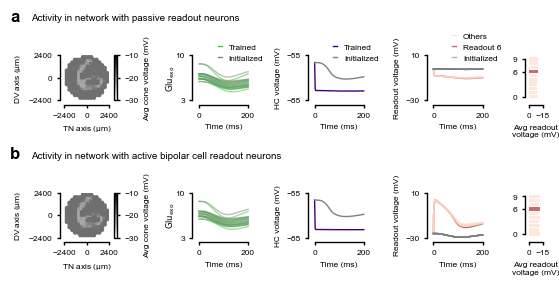

In [19]:
with mpl.rc_context(fname="../../.matplotlibrc"):

    voltage_colors = plt.cm.Purples([1.0, 1.0, 0.3])
    readout_colors = plt.cm.Reds([0.15, 0.9])
    _ = np.random.seed(0)
    rand_glu = np.random.choice(np.arange(0, 200, dtype=int), size=10)

    fig = plt.figure(figsize=(5.5, 2.75), layout="constrained")
    axs = fig.subplot_mosaic(
        [
            ['cones201n', '.', 'glu201n', 'hc201n', '.', 'readouts201n', 'hist201n'],
            ['cones201y', '.', 'glu201y', 'hc201y', '.', 'readouts201y', 'hist201y']
         ], 
        width_ratios=(4, 2.75, 4, 4, 0.25, 4, 1),
        )

    for i, x in enumerate(["201n", "201y"]):
        # Necessary data
        soln = data["solns"][i]
        init_soln = data["init_solns"][i]

        # Define the color of the photoreceptor based on its glutamate release to the target readout
        cone_v = np.mean(soln[model_config["n_readouts"]:model_config["n_readouts"]+model_config["nPRs"]], axis=1)
        voltage_scatter = axs[f'cones{x}'].scatter(coords[0], coords[1], c=cone_v, cmap='binary', s=5, vmin=-30, vmax=-10)
        axs[f'cones{x}'].set_aspect('equal')
        axs[f'cones{x}'].set_xlabel(r'TN axis $(\mu m)$')
        axs[f'cones{x}'].set_ylabel(r'DV axis $(\mu m)$')
        axs[f'cones{x}'].set_xticks([-2400, 0, 2400])
        axs[f'cones{x}'].set_yticks([-2400, 0, 2400])
        axs[f'cones{x}'].set_xlim(-2400, 2400)
        axs[f'cones{x}'].set_ylim(-2400, 2400)

        divider = make_axes_locatable(axs[f'cones{x}'])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(voltage_scatter, cax=cax)
        cbar.set_label("Avg cone voltage (mV)")
        cbar.set_ticks([-30, -20, -10])
        sns.despine(offset=3, ax=axs[f'cones{x}'])

        # Plot readouts
        readout_alpha = 0.6
        colors = [readout_colors[0]] * model_config["n_readouts"]
        colors[labels] = readout_colors[1]
        for i in range(0, model_config["n_readouts"]):
            axs[f'readouts{x}'].plot(time, soln[i, :], c=colors[i], alpha=readout_alpha)

        init_colors = ["grey"] * model_config["n_readouts"]
        for i in range(0, model_config["n_readouts"]):
            axs[f'readouts{x}'].plot(time, init_soln[i, :], c=init_colors[i], alpha=readout_alpha, label="Init.")

        # Custom legend with one line per color
        if x == "201n":
            legend_elements = [
                Line2D([0], [0], color=readout_colors[0], alpha=readout_alpha), # alpha=0.5
                Line2D([0], [0], color=readout_colors[1], alpha=readout_alpha), # 
                Line2D([0], [0], color='grey', alpha=readout_alpha), # lw=2
            ]
            axs[f'readouts{x}'].legend(
                legend_elements, 
                ['Others', f'Readout {labels}', 'Initialized'], 
                bbox_to_anchor=(0.25, 0.7),
                loc="lower left",
                handlelength=0.5,
                frameon=False
                )
        axs[f'readouts{x}'].set_xlabel("Time (ms)")
        axs[f'readouts{x}'].set_ylabel("Readout voltage (mV)")
        axs[f'readouts{x}'].spines["bottom"].set_bounds(0, 200)
        axs[f'readouts{x}'].set_xticks((0, 200))
        axs[f'readouts{x}'].set_ylim(-30, 10)
        axs[f'readouts{x}'].set_yticks((-30, 10))
        sns.despine(ax=axs[f'readouts{x}'], offset=3)

        axs[f'hist{x}'].barh(
            np.arange(model_config["n_readouts"]), 
            np.mean(soln[:model_config["n_readouts"], :], axis=1), 
            align='center', 
            color=colors,
            alpha=readout_alpha
            )
        axs[f'hist{x}'].invert_xaxis()
        axs[f'hist{x}'].set_yticks(np.arange(model_config["n_readouts"]), np.round(np.arange(model_config["n_readouts"]), 0))
        axs[f'hist{x}'].set_xlabel("Avg readout\nvoltage (mV)")
        axs[f'hist{x}'].spines["bottom"].set_bounds(0, -15)
        axs[f'hist{x}'].set_xticks([0, -15])
        axs[f'hist{x}'].set_yticks([0, 6, 9])
        axs[f'hist{x}'].spines["left"].set_bounds((0, 9))
        sns.despine(ax=axs[f'hist{x}'], offset=3)

        ncells = model_config["n_readouts"] + model_config["nPRs"]
        for i in range(ncells, ncells + model_config["nHCs"]):
            axs[f'hc{x}'].plot(time, soln[i, :], c=voltage_colors[1], label="Trained")
            axs[f'hc{x}'].plot(time, init_soln[i, :], c="grey", label="Initialized")
        axs[f'hc{x}'].set_xlabel("Time (ms)")
        axs[f'hc{x}'].set_ylabel("HC voltage (mV)")
        axs[f'hc{x}'].spines["bottom"].set_bounds(0, 200)
        axs[f'hc{x}'].set_xticks([0, 200])
        axs[f'hc{x}'].set_ylim(-85, -55)
        axs[f'hc{x}'].set_yticks([-85, -55])
        if x == "201n":
            leg = axs[f'hc{x}'].legend(handlelength=0.5, frameon=False, loc="lower left", bbox_to_anchor=(0.25, 0.7))

        sns.despine(ax=axs[f'hc{x}'], offset=3)

        # Add glutamate
        ncells = model_config["n_readouts"] + model_config["nPRs"] + model_config["nHCs"]
        for i in rand_glu + ncells:
            axs[f'glu{x}'].plot(time, soln[i], color="limegreen", alpha=0.5)
            axs[f'glu{x}'].plot(time, init_soln[i], color="grey", alpha=0.5)
        axs[f'glu{x}'].set_xlabel("Time (ms)")
        axs[f'glu{x}'].set_ylabel(r"$\mathrm{Glu_{exo}}$", labelpad=-1)
        axs[f'glu{x}'].spines["bottom"].set_bounds(0, 200)
        axs[f'glu{x}'].set_xticks([0, 200])
        axs[f'glu{x}'].set_yticks([3, 10])
        sns.despine(ax=axs[f'glu{x}'], offset=3)
        if x == "201n":
            legend_elements = [
                Line2D([0], [0], color='limegreen'),
                Line2D([0], [0], color='grey'), # lw=2
            ]
            axs[f'glu{x}'].legend(
                legend_elements, 
                ['Trained', 'Initialized'], 
                bbox_to_anchor=(0.25, 0.7),
                loc="lower left",
                handlelength=0.5,
                frameon=False
                )

        fig.align_xlabels()

    kwargs_text = {'fontsize': 12, 'font': 'Arial', 'weight': '800'}
    axs[f'cones201n'].text(-1.2, 1.75, "a", transform=axs[f'cones201n'].transAxes, **kwargs_text)
    axs[f'cones201y'].text(-1.2, 1.75, "b", transform=axs[f'cones201y'].transAxes, **kwargs_text)

    fig.text(0.05, 0.94, "Activity in network with passive readout neurons", ha="left", fontsize=7)
    fig.text(0.05, 0.44, "Activity in network with active bipolar cell readout neurons", ha="left", fontsize=7)

    plt.savefig(f"../fig/fig3.png", dpi=300)
    # plt.savefig("../fig/fig3.svg", transparent=True)
    plt.savefig("../fig/fig3.pdf", format="pdf", bbox_inches="tight")
    plt.show()

Small note: the luminance voltage values are a bit off because the luminance and contrast was randomized, and the seed somehow changed between versions and so on. One notices that this doesn't seem to affect the results much. One can regenerate the data for this plot with different random luminances in the mnist.ipynb notebook.